In [0]:
from tensorflow.python.client import device_lib

print("Show System RAM Memory:\n\n")
!cat /proc/meminfo | egrep "MemTotal*"

print("\n\nShow Devices:\n\n" +str(device_lib.list_local_devices()))

Show System RAM Memory:


MemTotal:       13335276 kB


Show Devices:

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1783898001676292482
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13054806917851599953
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17815470917087921337
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 12482658304
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4175027670943382433
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [0]:
import fastai
from fastai import *
from fastai.text import *
from fastai.core import *
import pickle
from fastai.callbacks import *

Train a Classifier

In [0]:
path = Path("/content/airline")
# Load the data
d_lm = load_data(path, 'data_lm_export.pkl')
d_clas = load_data(path, 'data_clas_export.pkl', bs=16)

In [0]:
learn_clas = text_classifier_learner(d_clas, AWD_LSTM, drop_mult=0.5)
#!mkdir airline

In [0]:
learn_clas.load_encoder('fine_T')
#!cd airline && mkdir models

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-02


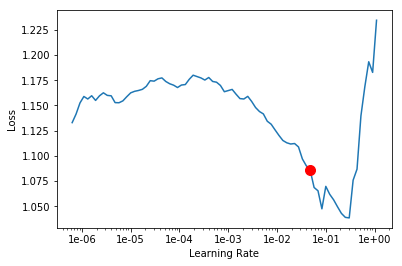

In [0]:
learn_clas.lr_find()
learn_clas.recorder.plot(suggestion=True)

In [0]:
learn_clas.fit_one_cycle(5, 1e-2, callbacks=[SaveModelCallback(learn_clas, name="best_lm")], moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.744298,0.573834,0.768522,00:20
1,0.715940,0.569225,0.776374,00:18
2,0.715931,0.544424,0.783202,00:20
3,0.680258,0.545109,0.771936,00:20
4,0.630930,0.539330,0.787641,00:20


Better model found at epoch 0 with val_loss value: 0.5738338232040405.
Better model found at epoch 1 with val_loss value: 0.5692247152328491.
Better model found at epoch 2 with val_loss value: 0.5444242358207703.
Better model found at epoch 4 with val_loss value: 0.539330244064331.


In [0]:

#Fine-tune the 1st 3 epochs after freezing everything except the last two layers

learn_clas.freeze_to(-2)
learn_clas.fit_one_cycle(3, slice(5e-3/2, 5e-3), callbacks=[SaveModelCallback(learn_clas, name="best_lm")], moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.590040,0.510827,0.803346,00:21
1,0.601142,0.491453,0.810516,00:21
2,0.500204,0.481348,0.815978,00:22


Better model found at epoch 0 with val_loss value: 0.5108272433280945.
Better model found at epoch 1 with val_loss value: 0.4914534389972687.
Better model found at epoch 2 with val_loss value: 0.48134753108024597.


In [0]:

# Unfreeze and fine-tune all layer now.

learn_clas.unfreeze()
learn_clas.fit_one_cycle(1, slice(2e-3/100, 2e-3), callbacks=[SaveModelCallback(learn_clas, name="best_lm")], moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.453211,0.480815,0.817685,00:38


Better model found at epoch 0 with val_loss value: 0.4808153808116913.


In [0]:
# Predicting a Positive sentiment

learn_clas.predict("Smoothest ever. It was hitch free and money well spent")

(Category 1, tensor(2), tensor([0.3422, 0.0485, 0.6094]))

In [0]:
# Predicting a Neutral sentiment

learn_clas.predict("Don't wanna be the judge or get caught up in this debate")


(Category 0, tensor(1), tensor([0.2983, 0.5267, 0.1751]))

In [0]:
# Predicting a Negative sentiment

learn_clas.predict("This was just an unprecendented display of ignorance. Wasted time")

(Category -1, tensor(0), tensor([0.8488, 0.0165, 0.1346]))

In [0]:
learn_clas.pred_batch

<bound method Learner.pred_batch of RNNLearner(data=TextClasDataBunch;

Train: LabelList (11711 items)
x: TextList
xxbos which is why my next flights to xxmaj miami will be on another airline .,xxbos i love you guys & i m gon na let you finish , but i ve been on hold for hour trying to book a flight w my voucher .,xxbos why are y all trying to fly me to xxmaj chicago when i do nt live there ? ! xxmaj send me home now xxrep 4 ! xxmaj bullshit ass customer service,xxbos xxmaj we hope you re still our bae ! xxunk man,xxbos xxmaj is it xxunk to upgrade a flight attendant in uniform vs passengers ? xxmaj one is in b on flt now to xxup iah
y: CategoryList
-1,-1,-1,0,-1
Path: /content/airline;

Valid: LabelList (2929 items)
x: TextList
xxbos xxmaj its the xxunk of xxup pr , let your customers have the most info possible . xxmaj might want to go brush up on the xxunk ...,xxbos flight , xxunk had the most excellent crew today,xxbos xxmaj cancelled xxmaj flightled flight , person line and one ag

In [0]:
learn_clas.save("sent_clas")